# Task 3 QSVM submission for the QC Mentorship program - Roberto Losada García

Generate a Quantum Support Vector Machine (QSVM) using the [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) and try to propose a kernel from a parametric quantum circuit to classify the three classes(setosa, versicolor, virginica) using the one-vs-all format, the kernel only works as binary classification. Identify the proposal with the lowest number of qubits and depth to obtain higher accuracy. You can use the $UU^{\dagger}$ format or using the [Swap-Test](https://en.wikipedia.org/wiki/Swap_test).

# Preliminar load of modules and auxiliary functions:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
seed=2023

In [2]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = seed # Reproducibility purposes
rand = algorithm_globals.random.uniform
# Note that once we fix this seed, every time we call rand, the points will be random but we will now the order

In [3]:
from IPython.core.interactiveshell import InteractiveShell

# This option will print all entries in a Jupyter notebook cell
InteractiveShell.ast_node_interactivity = "all"

# Return to normal
# InteractiveShell.ast_node_interactivity = "last_expr"

In [4]:
# Auxiliary functions to save and load the classifiers into pickle objects:
import pickle
def add_to_pickle(path, item):
    with open(path, 'wb') as file:
        pickle.dump(item, file, pickle.HIGHEST_PROTOCOL)
        
def load_from_pickle(path):
    objects = []
    with (open(path, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    if type(objects)==list and len(objects)==1:
        return objects[0]
    else:
        return objects

In [5]:
# Auxiliary function to plot Kernel matrixes:
def plot_matrixes(matrix_list, title_list=['train set','train set vs test set']):
    
    fig, axs = plt.subplots(nrows=1, ncols=len(title_list), figsize=(12, 7))
    
    for i,(matrix,label) in enumerate(zip(matrix_list,title_list)):
        axs[i].set_title(label)
        axs[i].imshow(matrix, cmap='viridis')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Preprocessing:

## Read the data

In [6]:
# Read the data file into a pandas DataFrame
df = pd.read_csv('iris.data', header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])

# Extract labels
y = df['class']

# Move labels to first column
# (in case we want to add new variables, such as petal area, etc.)
df.drop(columns=['class'], inplace=True)
df.insert(0, 'class', y)

# Extract the values of the features
X = df.iloc[:,1:]

# Retrieve the different labels and features
classes = df['class'].unique().tolist()
features = df.columns[1:].tolist()

In [7]:
# Note that there are 50 elements of each class:
df['class'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

In [8]:
# Note that there aren't any missing values:
print(df.isnull().sum())

class           0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
dtype: int64


## Visualize the data:

<AxesSubplot:>

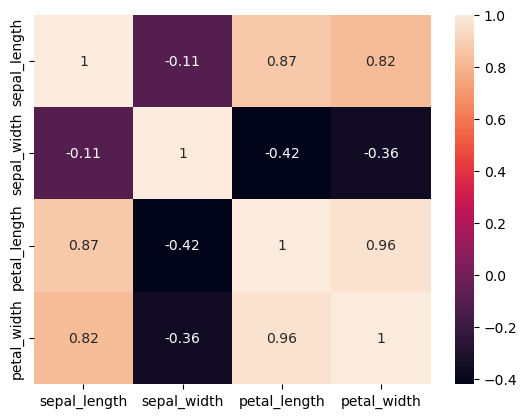

In [9]:
# Create a correlation matrix
corr_matrix = X.corr()
# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True)

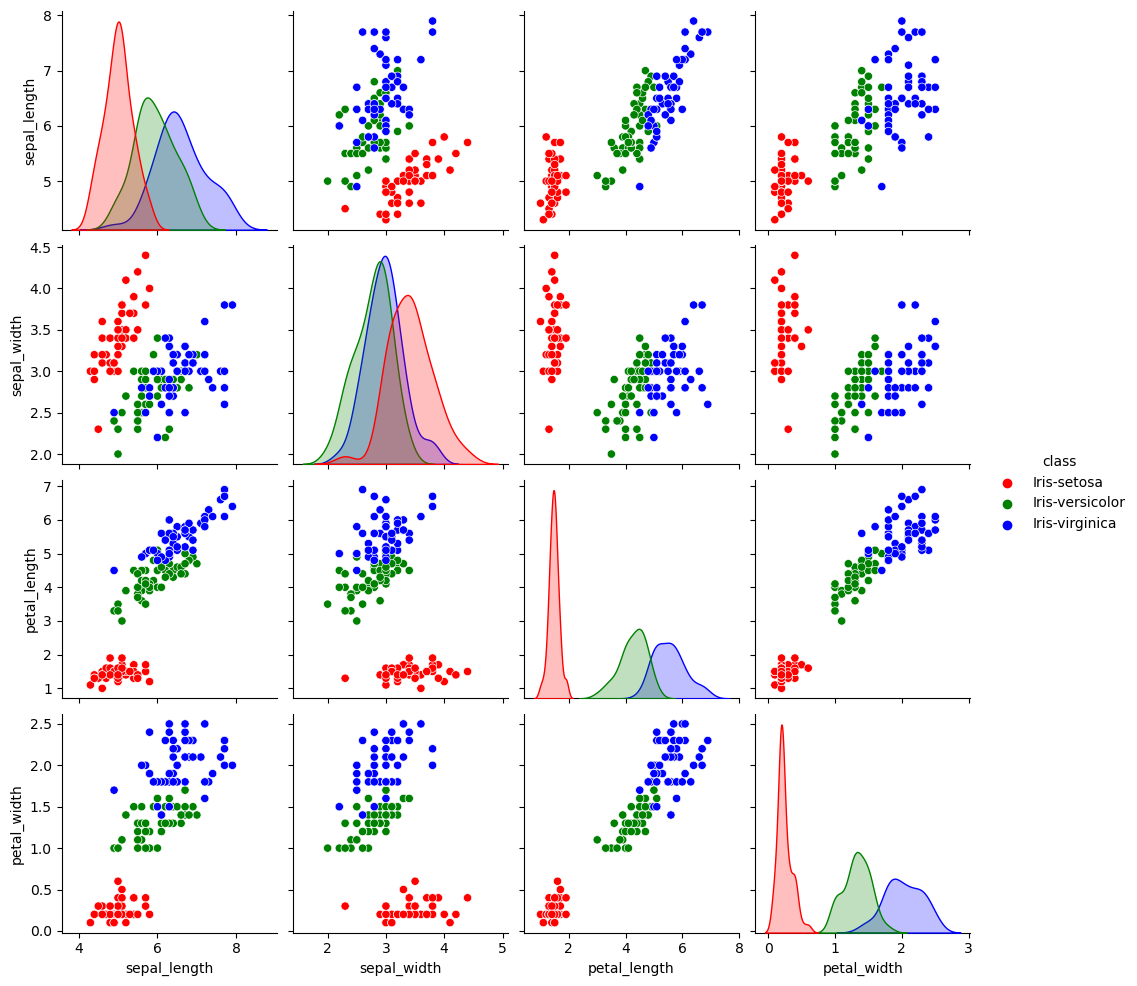

In [10]:
# Plot the scatter matrix with the seaborn package
palette = {'Iris-setosa': 'red', 'Iris-versicolor': 'green', 'Iris-virginica': 'blue'}
sns.pairplot(df, hue='class', palette=palette)
plt.show()

<AxesSubplot:xlabel='class', ylabel='sepal_length'>

<AxesSubplot:xlabel='class', ylabel='sepal_width'>

<AxesSubplot:xlabel='class', ylabel='petal_length'>

<AxesSubplot:xlabel='class', ylabel='petal_width'>

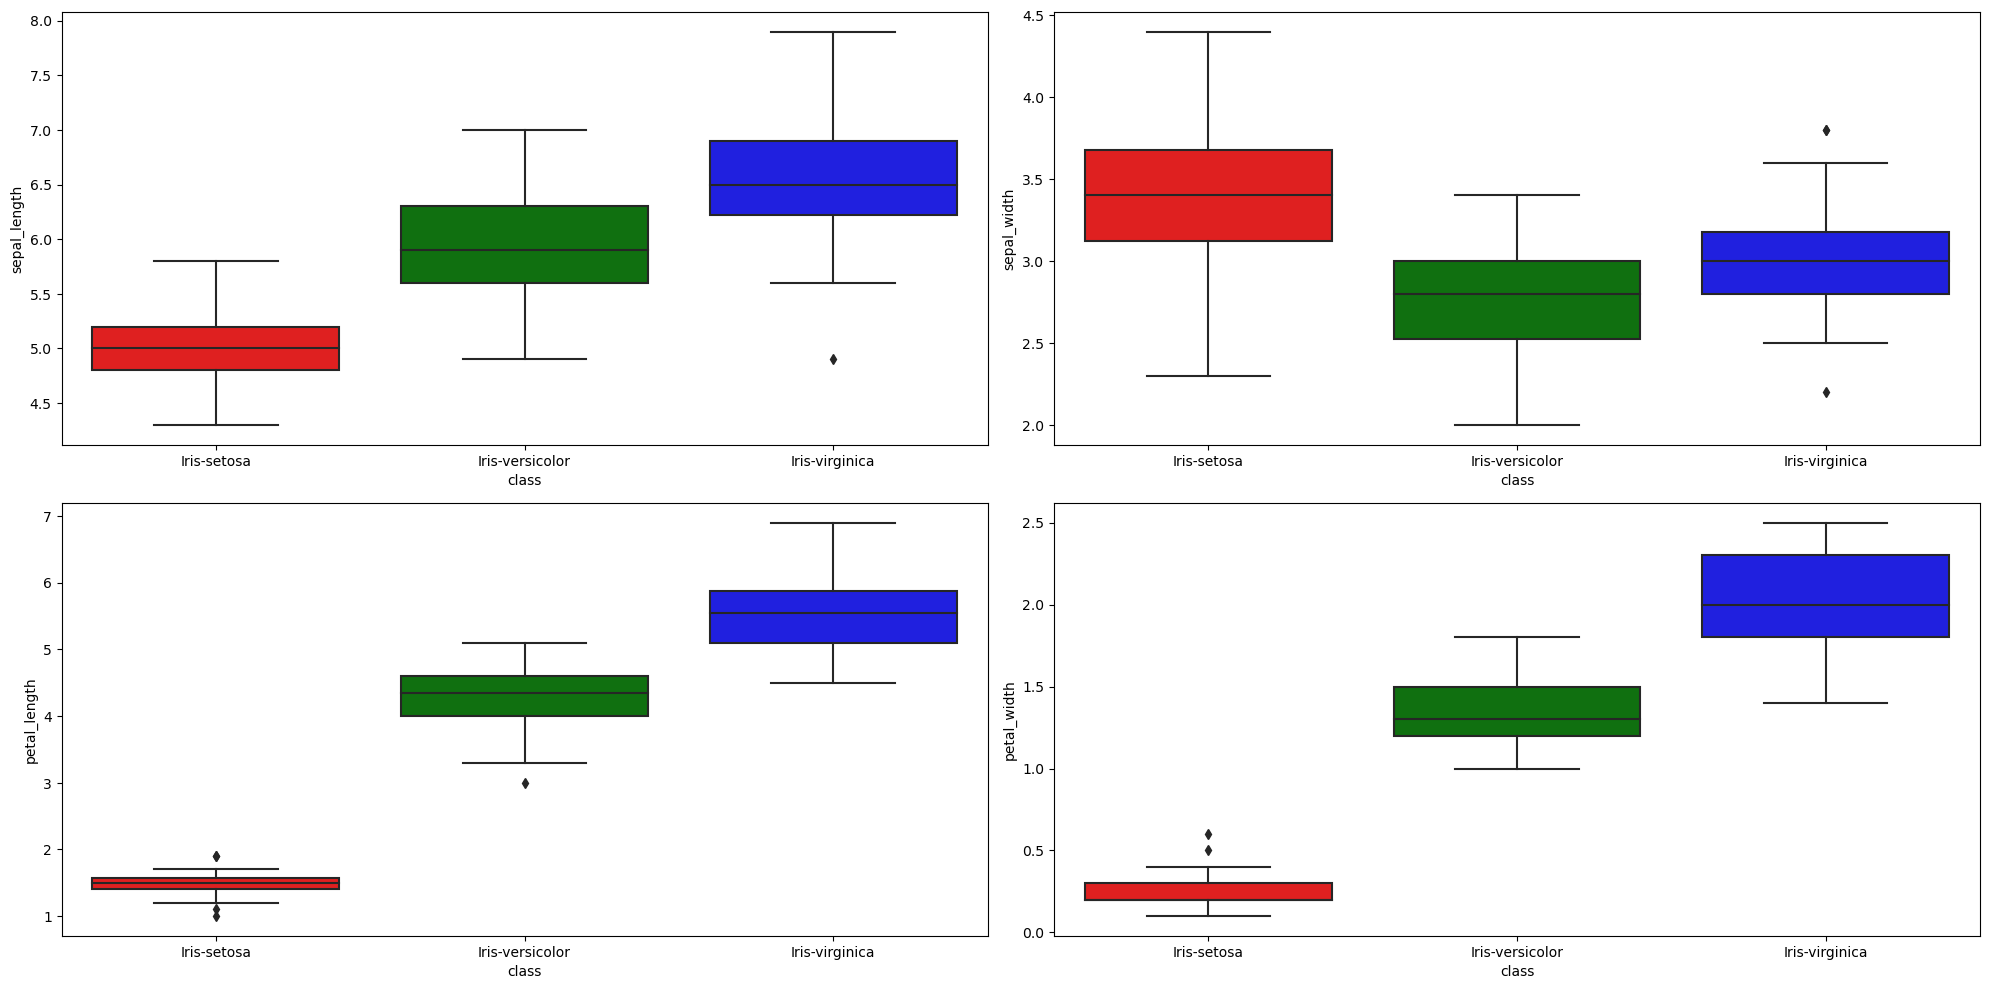

In [11]:
# Boxplots

fig, axs = plt.subplots(nrows=2, ncols=len(features)//2, figsize=(20, 10))
for i, feature in enumerate(features):
    row = i // (len(features)//2)
    col = i % (len(features)//2)
    sns.boxplot(data=df, x='class', y=str(feature), palette=palette, ax=axs[row, col])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='sepal_length', ylabel='Count'>

<AxesSubplot:xlabel='sepal_width', ylabel='Count'>

<AxesSubplot:xlabel='petal_length', ylabel='Count'>

<AxesSubplot:xlabel='petal_width', ylabel='Count'>

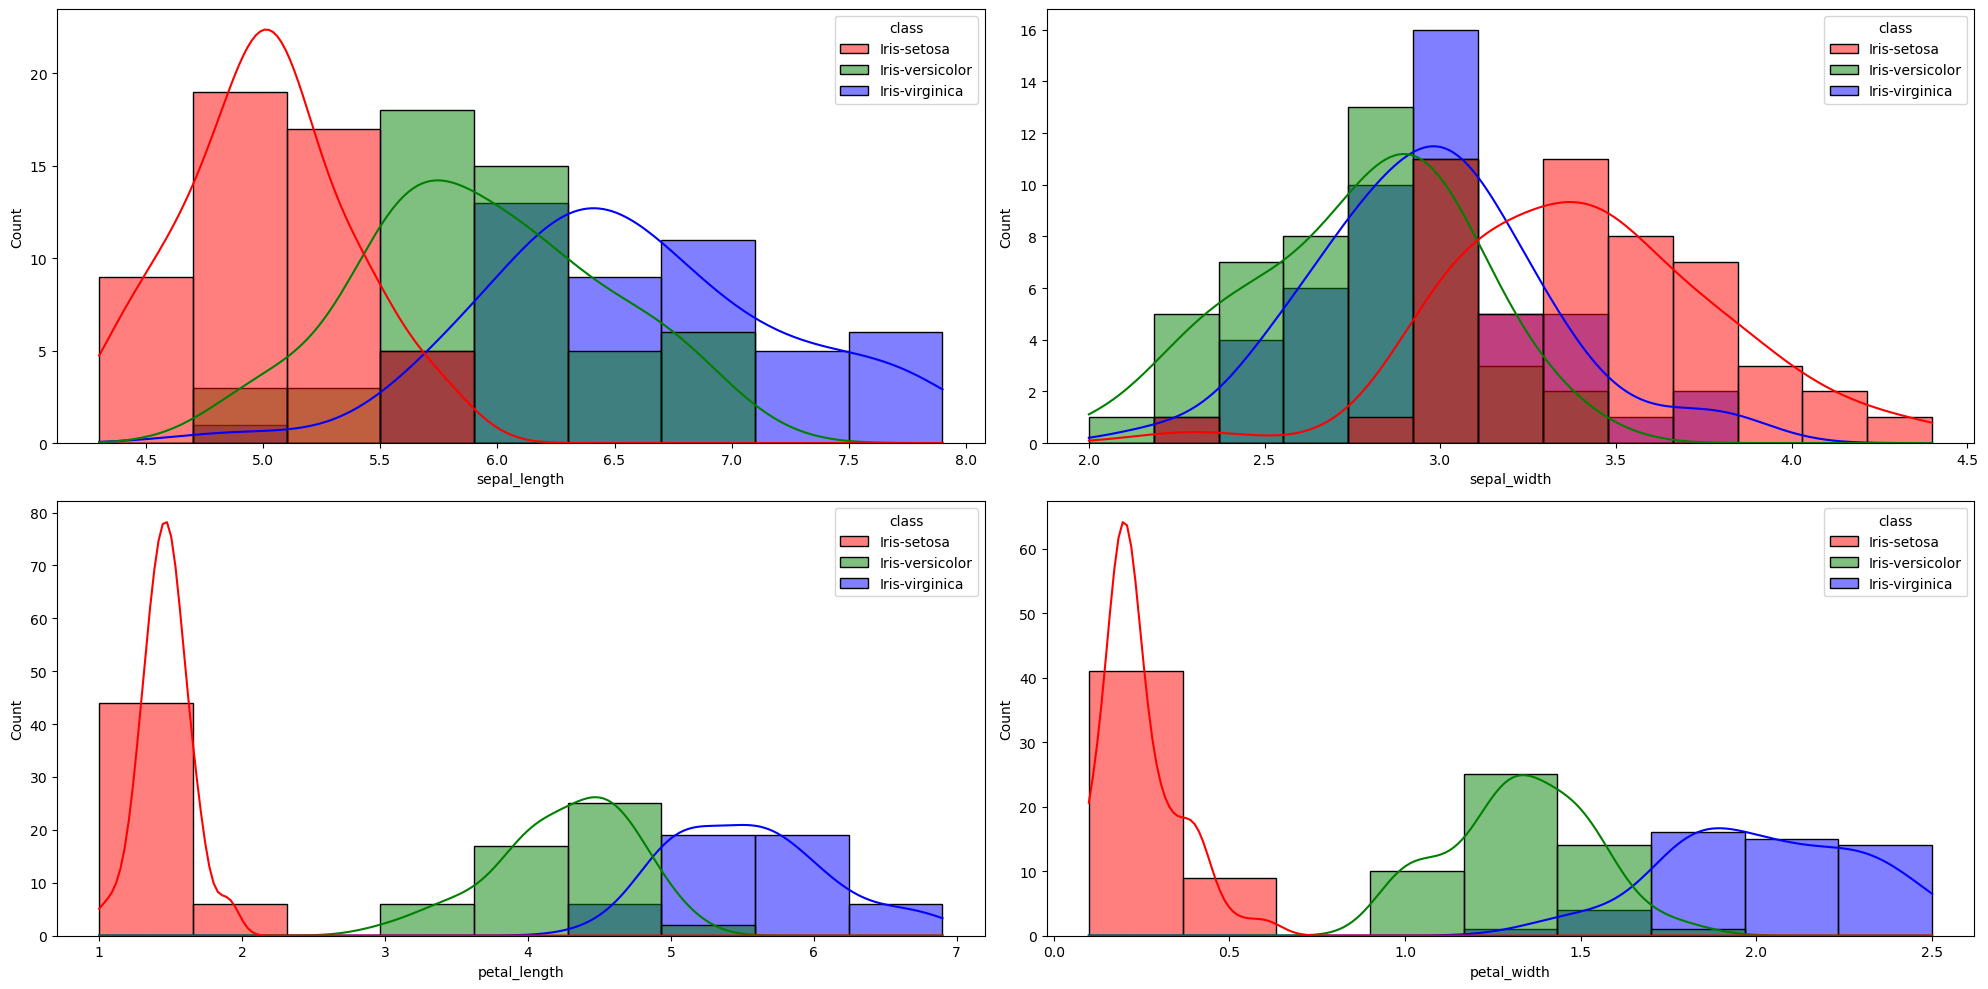

In [12]:
# Histplots
fig, axs = plt.subplots(nrows=2, ncols=len(features)//2, figsize=(20, 10))
for i, feature in enumerate(features):
    row = i // (len(features)//2)
    col = i % (len(features)//2)
    sns.histplot(data=df, x=str(feature), hue='class', palette=palette, kde=True, alpha=0.5, ax=axs[row, col])
plt.tight_layout()
plt.show()

## Reescaling the data:

Since we will be encoding the features into quantum rotation gates (angle encoding), we will reescale the data to be in between $[0, 2 \pi)$

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler((-np.pi,np.pi)).fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

## Split the data:

We will divide the dataset of length 150 in a balanced train set of 117 elements (78%) and a test set of 42 elements.
The train set will be subdivided in 3 sub-train sets each one of 39 elements consisting of 13 elements of each class.

The test set will be 'tested' for the 3 support vector machines at the same time, while each kernel's classifier will be trained on a different balanced dataset.

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
# Divide the dataframe in a train set and test set.
split = StratifiedShuffleSplit(n_splits=1, test_size=42, random_state=seed)
for train_index, test_index in split.split(X_scaled, y):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [17]:
# Check that data is balanced
y_train.value_counts()
y_test.value_counts()

Iris-versicolor    36
Iris-setosa        36
Iris-virginica     36
Name: class, dtype: int64

Iris-virginica     14
Iris-setosa        14
Iris-versicolor    14
Name: class, dtype: int64

In [18]:
#Insert the labels for creating evenly the sub-train sets
X_train.insert(0, 'class', y_train)

# Group the data by class
grouped = X_train.groupby('class')

In [19]:
# Split each group in 3 subgroups after having shuffled.
subgroups = [np.array_split(grouped.get_group(label).sample(frac=1, random_state=seed), 3) for label in classes]

In [20]:
# Join the 3 subgroups into each sub train set, and shuffle to mix the classess
X_subtrain_sets = []
y_subtrain_sets = []
for k in range(3):
    # Concatenate each class subgroup created
    concat_subgroup = pd.concat(item[k] for item in subgroups)
    
    # Shuffle to mix the different classes
    shuffled_subgroup = concat_subgroup.sample(frac=1, random_state=seed)
    
    # Extract labels
    y_subtrain_sets.append(shuffled_subgroup['class'].apply(lambda x: 1 if x==classes[k] else 0))
    
    # Extract values
    X_subtrain_sets.append(shuffled_subgroup.iloc[:,1:])
X_train_1, X_train_2, X_train_3 = X_subtrain_sets
y_train_1, y_train_2, y_train_3 = y_subtrain_sets

In [21]:
# Consistency check to see that every train group has 12 elements of each class!
[y_train_set.value_counts() for y_train_set in y_subtrain_sets]

[0    24
 1    12
 Name: class, dtype: int64,
 0    24
 1    12
 Name: class, dtype: int64,
 0    24
 1    12
 Name: class, dtype: int64]

# Classification with a Quantum Support Vector Machine

## Parametrized feature maps

Since we have 4 features, and we will encode our features in a parametrized QisKit circuit, we won't be needing more than 2 qubits.

In [22]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms.classifiers import QSVC
from tqdm import tqdm

In [23]:
n = 2 # qubits
N = 4 # features

We will use an ansatz with 6 parameters:
- 4 first parameters: Feature encoding (angle encoding)
- 2 last parameters: Kernel training

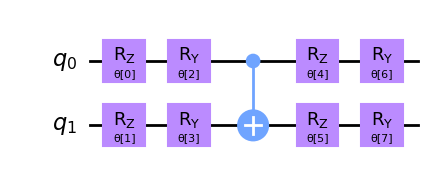

In [24]:
TwoLocal(
    num_qubits=n,
    rotation_blocks=['rz','ry'],
    entanglement_blocks='cx',
    reps=1,
    entanglement='pairwise' # Doesn't really matter since we are with 2 qubits.
    ).decompose().draw('mpl',fold=-1)

We will try to use only 2 trainable parameters! So we define the same circuit without the final gates!

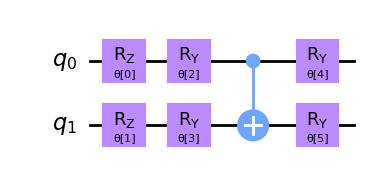

In [25]:
# We skip the final rotation layers
TL = TwoLocal(
    num_qubits=n,
    rotation_blocks=['rz','ry'],
    entanglement_blocks='cx',
    reps=1,
    entanglement='pairwise',
    skip_final_rotation_layer=True
).decompose()

# Add only 2 rotation gates!
P = ParameterVector('θ',N+2)
for i in range(2):
    TL.ry(P[i+4],i)
TL.draw('mpl',fold=-1)

The idea will be to fix the last two parameters randomly, as they are trainable ones, and optimize them based on a loss function.
We can do this manually, but QisKit has now a class that allows to implement this much more quickly.

In [26]:
# Fix randomly the last 2 parameters for each dataset
initial_training_parameters_list = [{item:rand(-np.pi,np.pi,1)[0] for item in TL.parameters[4:6]} for i in range(3)]
initial_training_parameters_list

[{ParameterVectorElement(θ[4]): -2.5883301971925565,
  ParameterVectorElement(θ[5]): -1.7565270058958784},
 {ParameterVectorElement(θ[4]): -2.4305210900314895,
  ParameterVectorElement(θ[5]): -0.3583499457220696},
 {ParameterVectorElement(θ[4]): 1.2398698888567505,
  ParameterVectorElement(θ[5]): 0.29017097583738405}]

## Trainable Fidelity Quantum Kernel

In this first approach we will use the default fidelity computation, using the Statevector simulation through the Sampler primitive (which is the default configuration).

I want to clarify 2 issues I have encountered while approaching the training of the `TrainableFidelityQuantumKernel` class.
- It isn't possible to run the training procedure in a QisKit IBM Runtime session, I have risen an issue (https://github.com/Qiskit/qiskit-ibm-runtime/issues/745) after having posted the problem I had in Stack Overflow (https://stackoverflow.com/q/75688554/11351319).
- Training the quantum kernel with bounds for the parameters isn't supported by the native `QuantumKernelTrainer` class. I have also opened an issue at the GitHub repo (https://github.com/Qiskit/qiskit-machine-learning/issues/570) and it looks like there are going to be some changes regarding QisKit optimizers classess in the next Terra releases (https://github.com/Qiskit/qiskit-terra/issues/9718).

  - In the meantime, downloading the last version of the git repository of `qiskit_machine_learning` with

    `pip install git+https://github.com/Qiskit/qiskit-machine-learning.git`,
    
    this issue can be patched with the following callable function:

In [27]:
def custom_optimizer(fun,x0):
    return SLSQP(maxiter=1000).minimize(fun=fun,x0=x0,bounds=[(-np.pi,np.pi)])

In [28]:
TFQK = TrainableFidelityQuantumKernel(
    feature_map=TL,
    training_parameters=TL.parameters[4:6])

In [29]:
# Define the trainer of our quantum kernel:
# We initialize each trainer with a different initial point
QKT_list = [QuantumKernelTrainer(
    quantum_kernel=TFQK,
    loss="svc_loss",
    optimizer=custom_optimizer, # Alternatively use SLSQP(maxiter=1000),
    initial_point=list(intial_params.values()))
            for intial_params in initial_training_parameters_list
           ]

In [30]:
# Run the trainer in every training set
QKT_results = [QKT_list[i].fit(X_subtrain_sets[i], y_subtrain_sets[i]) for i in tqdm(range(3))]

100%|██████████| 3/3 [00:30<00:00, 10.07s/it]


In [31]:
QKT_opt_params = [QKT_results[k].quantum_kernel.parameter_values for k in range(3)]
print("Optimal training paramters",QKT_opt_params)

# Note that initial points are indeed not optimal points, so an optimization has taken place!
# [np.allclose(QKT_opt_params[k],list(initial_training_parameters_list[k].values())) for k in range(3)]

Optimal training paramters [array([-2.5888705 , -1.75787962]), array([-2.43052109, -0.36106795]), array([1.24172704, 0.29295557])]


In [32]:
QKT_opt_values = [QKT_results[k].optimal_value for k in range(3)]
print("svc_loss optimized value",QKT_opt_values)

svc_loss optimized value [2.8638886198710325, 9.467884246064997, 4.962239633060094]


In [33]:
# Retrieve the optimal quantum kernels
QKT_optimized_kernels = [results.quantum_kernel for results in QKT_results]

## Quantum Kernel matrixes

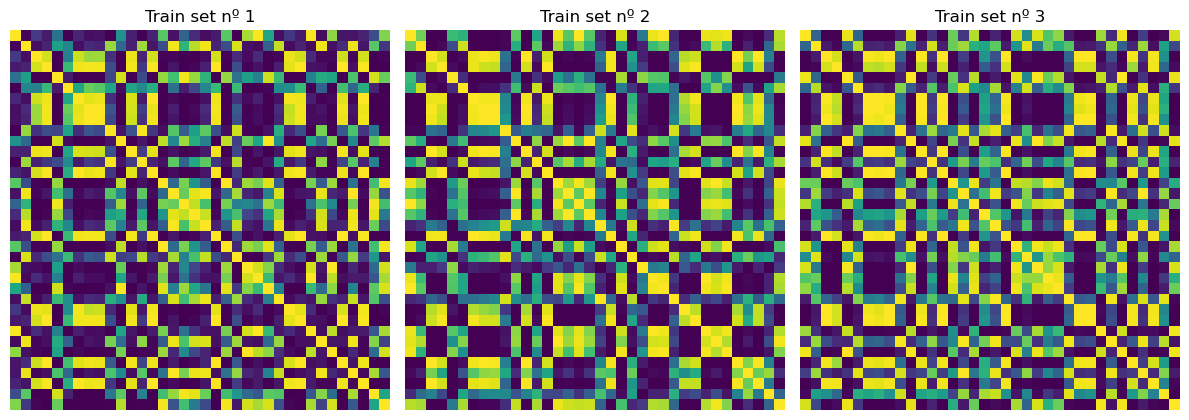

In [34]:
Trained_kernels = [QKT_optimized_kernels[i].evaluate(X_subtrain_sets[i]) for i in range(3)]
plot_matrixes(Trained_kernels,['Train set nº '+str(i) for i in range(1,4)])

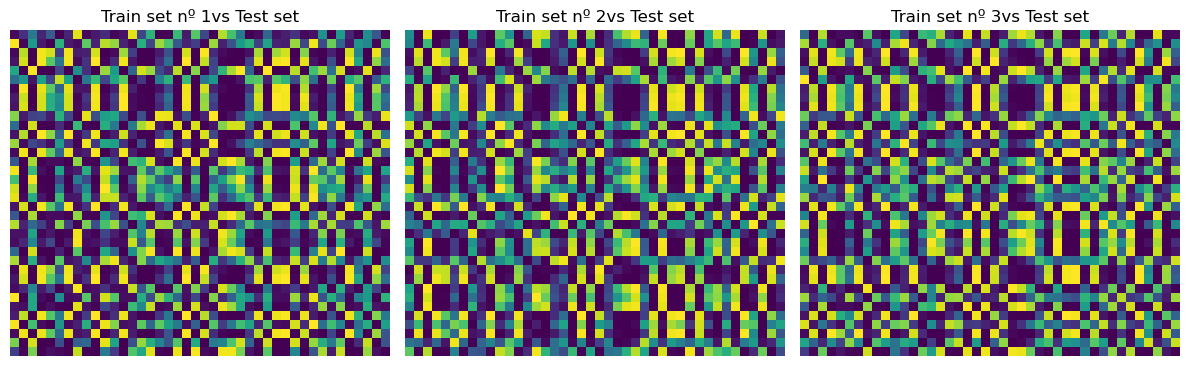

In [35]:
Train_vs_test_set_kernels = [QKT_optimized_kernels[i].evaluate(X_subtrain_sets[i],X_test) for i in range(3)]
plot_matrixes(Train_vs_test_set_kernels,['Train set nº '+str(i)+'vs Test set' for i in range(1,4)])

## Quantum Support Vector Classifiers

Define the native QisKit Quantum Support Vector Classifier, giving as kernel our quantum trained kernels and with the `probability=True` option enabled to give a likelihood when predicting labels

In [36]:
QSVC_list = [QSVC(quantum_kernel=optimized_kernel,probability=True) for optimized_kernel in QKT_optimized_kernels]

# Fit them with the train data
for i in tqdm(range(3)):
    QSVC_list[i].fit(X_subtrain_sets[i], y_subtrain_sets[i])

  0%|          | 0/3 [00:00<?, ?it/s]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb6054b7310>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)

 33%|███▎      | 1/3 [00:00<00:01,  1.30it/s]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb60e41a550>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)

 67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb6042cad00>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)

100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


In [37]:
# Consistency check that they perform well over the train set:
# QSVC_train_score = [QSVC_list[i].score(X_subtrain_sets[i], y_subtrain_sets[i]) for i in tqdm(range(3))]
# print(QSVC_train_score)

### Performance score over the test set

In [38]:
# Score of performance of each classifier over test set
QSVC_test_score = [QSVC_list[i].score(X_test, y_test.apply(lambda x: 1 if x==classes[i] else 0)) for i in tqdm(range(3))]
# Note that y_test contains the 3 different labels, we set to 0 the other 2 labels
print(QSVC_test_score)

100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

[1.0, 0.9523809523809523, 0.9523809523809523]


To evaluate the joint performance of the 3 classifiers over the whole test set, we will chose the label of the prediction with highest probability.

We only need the probability of the item in the test set being of the class that distinguishes the classifier that has been trained with the one vs all approach.

In [39]:
# Obtain the predicted probabilities for each class for each example in X_test
QSVC_test_predictions = [QSVC_list[i].predict_proba(X_test)[:,1] for i in range(3)]

# Combine the predicted probabilities for all classes into a single matrix
QSVC_stacked_test_predictions = np.vstack(QSVC_test_predictions).T

# Obtain the predicted labels (0,1 or 2) with the highest confidence
QSVC_predicted_labels = np.argmax(QSVC_stacked_test_predictions, axis=1)

In [40]:
QSVC_missclassified = []
for index,(predicted_label, true_label) in enumerate(zip(QSVC_predicted_labels,y_test)):
    # Match the numeric labels (0,1 or 2) with the names in the 'classes' objects
    if classes[predicted_label] != true_label:
        QSVC_missclassified.append(index)
print(f"There are {len(QSVC_missclassified)} missclassified items out of {len(y_test)}: {QSVC_missclassified}")

There are 2 missclassified items out of 42: [14, 31]


In [41]:
QSVC_accuracy = 1-(len(QSVC_missclassified)/len(y_test))
print("Statevector SVM joint accuracy",QSVC_accuracy)

Statevector SVM joint accuracy 0.9523809523809523


95% is quite a good score for the classifier!

### Missclassified data:

In [42]:
QSVC_predictions = pd.concat([pd.DataFrame(QSVC_test_predictions).transpose(), pd.DataFrame(y_test.values)], axis=1)
QSVC_predictions.columns = [item+' vs. all' for item in classes]+['true_value']
QSVC_predictions.iloc[QSVC_missclassified]

,Iris-setosa vs. all,Iris-versicolor vs. all,Iris-virginica vs. all,true_value
14,0.035238,0.483372,0.20286,Iris-virginica
31,0.026502,0.323092,0.52952,Iris-versicolor


In [43]:
# Default colors
QSVC_colors = [palette[y_test.iloc[i]] for i in range(len(y_test))] 
new_colors = ['yellow','orange','pink','purple','brown']
count = 0
for index in QSVC_missclassified:
    QSVC_colors[index] = new_colors[count]
    count +=1

In [44]:
# De-escale the test set and see the missclassified case
X_test_invscaled = pd.DataFrame(scaler.inverse_transform(X_test), columns=X_test.columns)
X_test_invscaled.iloc[QSVC_missclassified]

,sepal_length,sepal_width,petal_length,petal_width
14,6.3,2.8,5.1,1.5
31,6.7,3.0,5.0,1.7


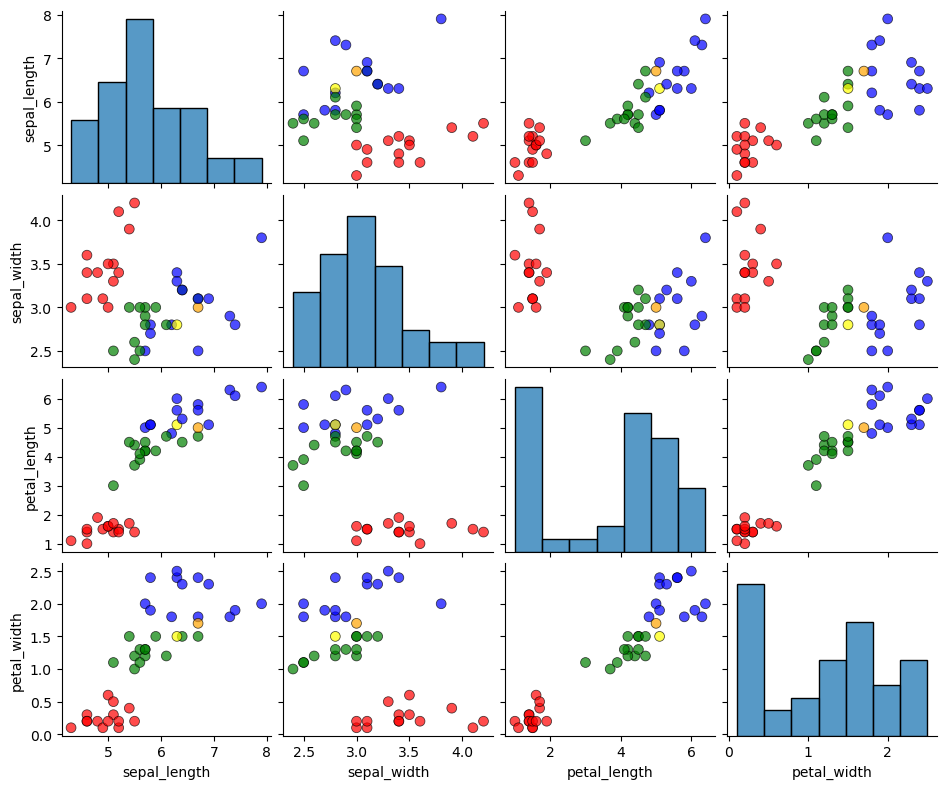

True colors {'Iris-setosa': 'red', 'Iris-versicolor': 'green', 'Iris-virginica': 'blue'}


Item 14, yellow data point has been classified as 'Iris-versicolor'(green) with a likelihood of 48.34%. True label is 'Iris-virginica' (blue)
Item 31, orange data point has been classified as 'Iris-virginica'(blue) with a likelihood of 52.95%. True label is 'Iris-versicolor' (green)


In [45]:
sns.pairplot(X_test_invscaled, plot_kws={'s': 50, 'edgecolor': 'k', 'alpha': 0.7, 'color': QSVC_colors}, height=2, aspect=1.2, diag_kind='hist')
plt.show()
print("True colors",palette)
print("\n")
for index in QSVC_missclassified:
    print(f"Item {index}, {QSVC_colors[index]} data point has been classified as '{classes[np.argmax(QSVC_predictions.iloc[index].tolist()[:-1])]}'"
          f"({palette[classes[np.argmax(QSVC_predictions.iloc[index].tolist()[:-1])]]})"
          f" with a likelihood of {np.round(np.max(QSVC_predictions.iloc[index].tolist()[:-1])*100,2)}%."
          f" True label is '{QSVC_predictions.iloc[index].tolist()[-1]}' ({palette[QSVC_predictions.iloc[index].tolist()[-1]]})")

# [Bonus] Aer simulation, without noise, noisy and with error mitigation for the quantum kernels Vs Classical classifier

## Aer Quantum Support Vector Classifier

In [46]:
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler, BackendSampler

By default the trainable quantum kernel sets fidelity as ``ComputeUncompute(sampler=Sampler())``, 
meaningly the ``Sampler`` primitive is doing an Statevector simulation since it is based on the Statevector construct (i.e. algebraic simulation).
We will run the quantum kernels with the standard aer backend via ``AerSimulator()`` and also running it with a noise model to compare with

In [47]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeBackendV2
from qiskit_aer.noise import NoiseModel

In [48]:
aer_backend = AerSimulator()
noisy_backend = FakeBackendV2()
noise_model = NoiseModel.from_backend(noisy_backend)

options_sim = {
    'simulator': {"seed_simulator": seed},
    'resilience_level': 0
}

options_noise = {
    'simulator': {
        "noise_model": noise_model,
        "seed_simulator": seed
    },
    'resilience_level': 0
}

options_list = [options_sim,options_noise]

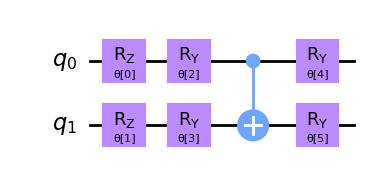

In [49]:
# We will use the same circuit
TL.draw()

In [50]:
# We fix new random training parameters for the 9 circuits (one per sub train set and per method)
aer_initial_training_parameters_list = [[{item:rand(-np.pi,np.pi,1)[0] for item in TL.parameters[4:6]} for i in range(2)] for k in range(3)]
aer_initial_training_parameters_list

[[{ParameterVectorElement(θ[4]): 1.645318057313193,
   ParameterVectorElement(θ[5]): 0.5334504944367562},
  {ParameterVectorElement(θ[4]): 2.4914495473586173,
   ParameterVectorElement(θ[5]): -2.19404628858427}],
 [{ParameterVectorElement(θ[4]): 0.02601643154490052,
   ParameterVectorElement(θ[5]): 2.207827723631043},
  {ParameterVectorElement(θ[4]): -1.9935451981655543,
   ParameterVectorElement(θ[5]): 0.7123700470400931}],
 [{ParameterVectorElement(θ[4]): -1.3515938403680503,
   ParameterVectorElement(θ[5]): 2.2594987667797053},
  {ParameterVectorElement(θ[4]): 0.24318568440492028,
   ParameterVectorElement(θ[5]): -0.38187394341751446}]]

### Train with aer the Trainable Fidelity Quantum Kernels

In [51]:
# Define a Trainable Fidelity Quantum Kernel per simulation method
aer_TFQK_list = [TrainableFidelityQuantumKernel(
    feature_map=TL,
    fidelity=ComputeUncompute(sampler=BackendSampler(backend=aer_backend,options=config)),
    training_parameters=TL.parameters[4:6]
) for config in options_list]

# Define 3 Quantum Kernel Trainers per method (for each training set)
aer_QKT_list = [[QuantumKernelTrainer(
    quantum_kernel=TFQK,
    loss="svc_loss",
    optimizer=custom_optimizer, # alternatively use optimzier=SLSQP(maxiter=1000),
    initial_point=list(aer_initial_training_parameters_list[k][i].values())
) for i,TFQK in enumerate(aer_TFQK_list)] for k in range(3)]

We will train the 2 types of Quantum Kernels (statevector aer simulation and noisy aer simulation) over the 3 sub-train datasets.

IMPORTANT: The training process can last for some time since we are using a noisy model. Therefore, it is recommended to skip to the cell where the ``aer_qkernels`` list is loaded via ``load_from_pickle`` function.

In [52]:
%%time
aer_QKT_fit_results = [
    [QKT.fit(X_subtrain_sets[k], y_subtrain_sets[k]) for QKT in tqdm(sub_train_set,leave=False)]
    for k,sub_train_set in tqdm(enumerate(aer_QKT_list))
]

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:58<00:00, 25.69s/it]
1it [00:58, 58.23s/it]                       
100%|██████████| 2/2 [00:56<00:00, 25.21s/it]
2it [01:55, 57.49s/it]                       
100%|██████████| 2/2 [00:18<00:00,  9.32s/it]
3it [02:13, 44.60s/it]                       

CPU times: user 1min 45s, sys: 15.5 s, total: 2min
Wall time: 2min 13s


In [53]:
# Retrieve the optimized quantum kernels
aer_qkernels = [[qkernel.quantum_kernel for qkernel in sub_train_set] for sub_train_set in aer_QKT_fit_results]

In [54]:
add_to_pickle('aer_qkernels.dat',aer_qkernels)
add_to_pickle('aer_QKT_fit_results.dat',aer_QKT_fit_results)

In [55]:
# # YOU MAY RUN THIS CELL INSTEAD OF THE 3 PREVIOUS ONES:
# aer_qkernels = load_from_pickle('aer_qkernels.dat')
# aer_QKT_fit_results = load_from_pickle('aer_QKT_fit_results.dat')

Recall that the structure of these lists is ``Sub_train datasets > Simulation_method``

In [56]:
aer_opt_params = [[aer_qkernels[k][i].parameter_values for i in range(2)] for k in range(3)]
print("Optimal training paramters \n",aer_opt_params)

# Note that initial points are indeed not optimal points, so an optimization has taken place!
# [[np.allclose(aer_opt_params[k][i],list(aer_initial_training_parameters_list[k][i].values())) for i in range(2)] for k in range(3)]

Optimal training paramters 
 [[array([1.64677926, 0.52986158]), array([ 2.49144955, -2.19404629])], [array([0.02905899, 2.2087396 ]), array([-1.9935452 ,  0.71237005])], [array([-1.35159384,  2.25949877]), array([ 0.24318568, -0.38187394])]]


[[False, True], [False, True], [True, True]]

In [57]:
aer_opt_values = [[aer_QKT_fit_results[k][i].optimal_value for i in range(2)] for k in range(3)]
print("svc_loss optimized value",aer_opt_values)

svc_loss optimized value [[2.801804319731885, 2.8431539490343303], [9.407225913406021, 9.345323595120718], [4.933126332542803, 4.834957672939366]]


### Aer Quantum Kernel matrixes

IMPORTANT: Building the kernel matrixes may take some minutes, consider loading them in the cell that reads ``load_from_pickle``

In [58]:
%%time
# Obtin the corresponding kernel matrixes:
aer_trained_kernels = [[qkernel.evaluate(X_subtrain_sets[k]) for qkernel in sub_train_set] for k,sub_train_set in enumerate(aer_qkernels)]
aer_trained_vs_test_kernels = [[qkernel.evaluate(X_subtrain_sets[k],X_test) for qkernel in sub_train_set] for k,sub_train_set in enumerate(aer_qkernels)]

CPU times: user 1min 9s, sys: 4.54 s, total: 1min 14s
Wall time: 1min 17s


In [59]:
add_to_pickle('aer_trained_kernels.dat',aer_trained_kernels)
add_to_pickle('aer_trained_vs_test_kernels.dat',aer_trained_vs_test_kernels)

In [60]:
# aer_trained_kernels = load_from_pickle('aer_trained_kernels.dat')
# aer_trained_vs_test_kernels = load_from_pickle('aer_trained_vs_test_kernels.dat')

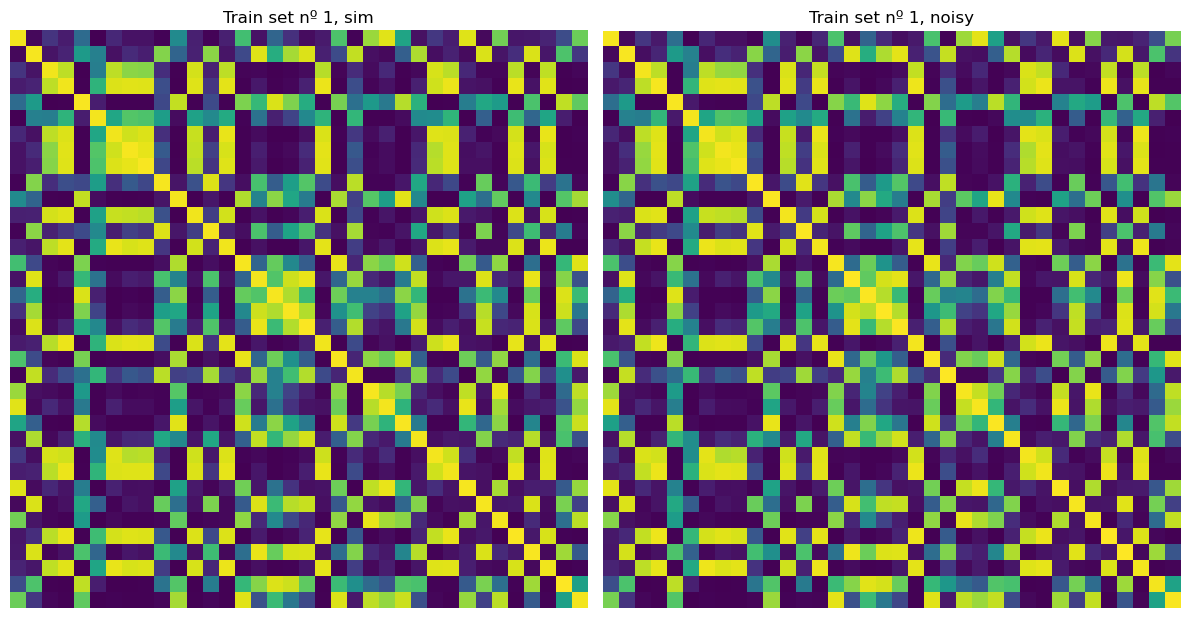

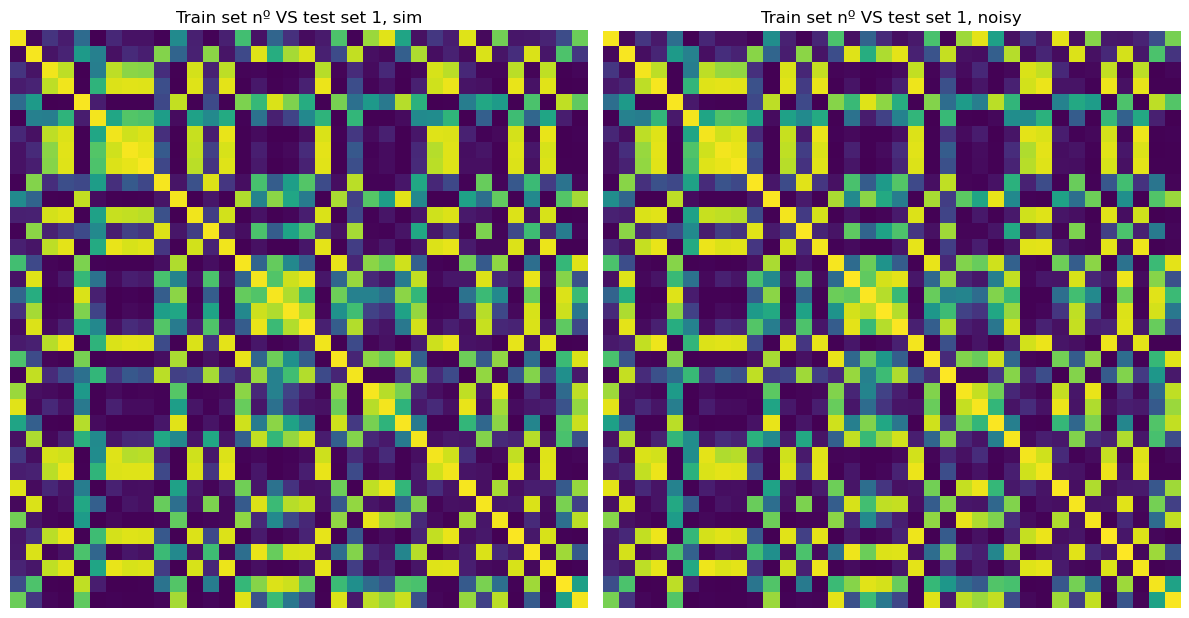

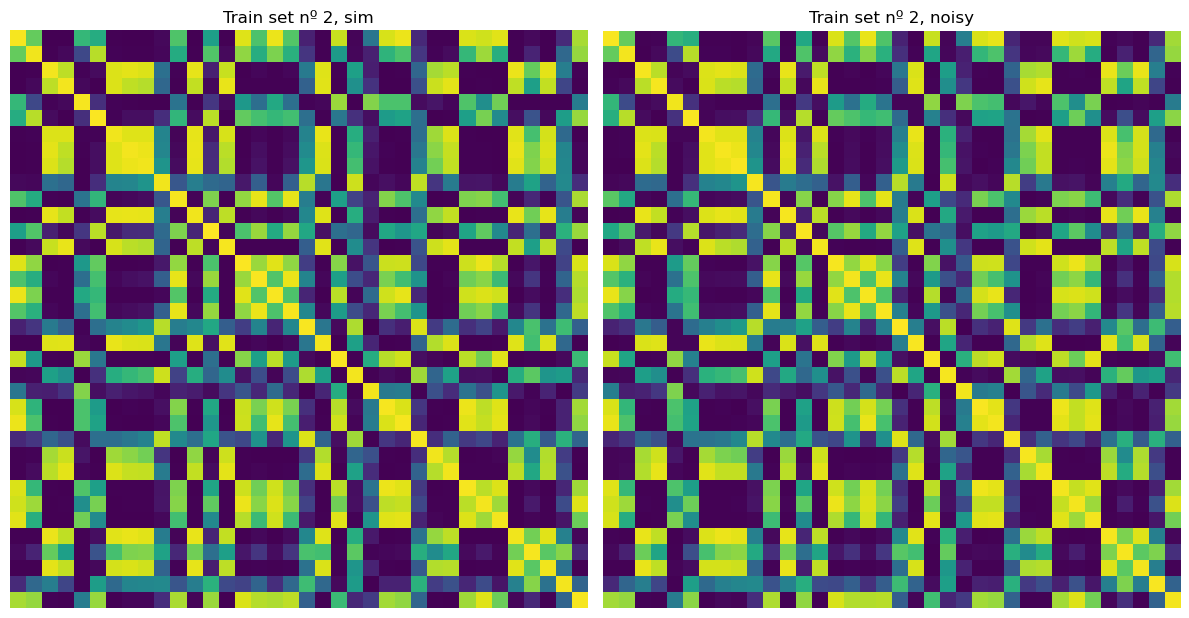

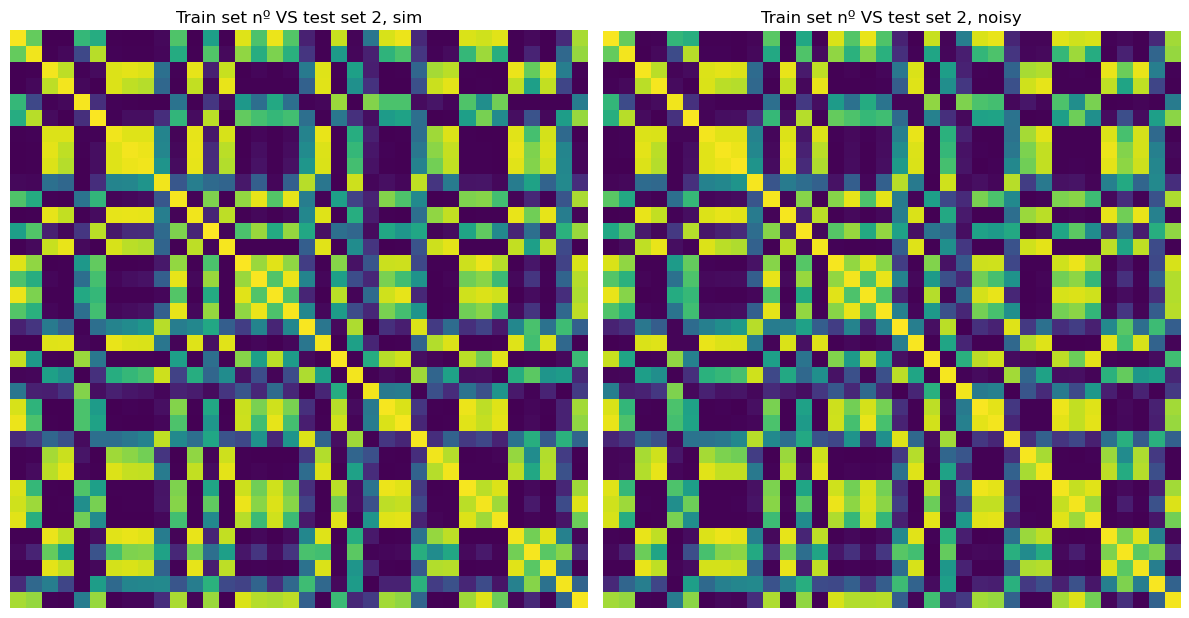

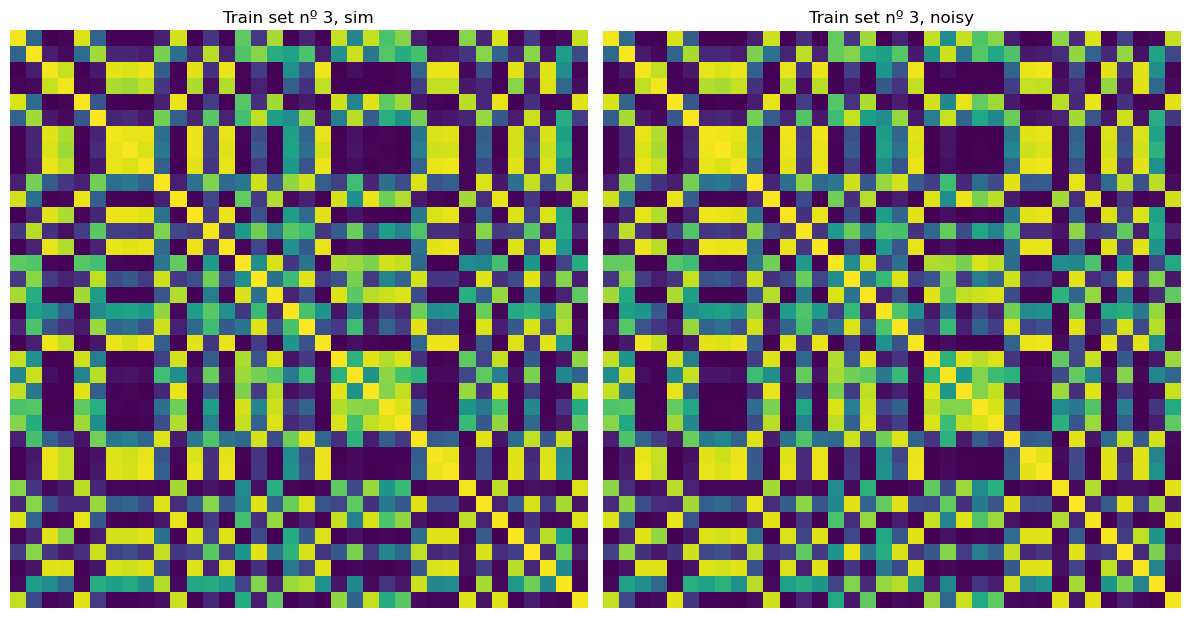

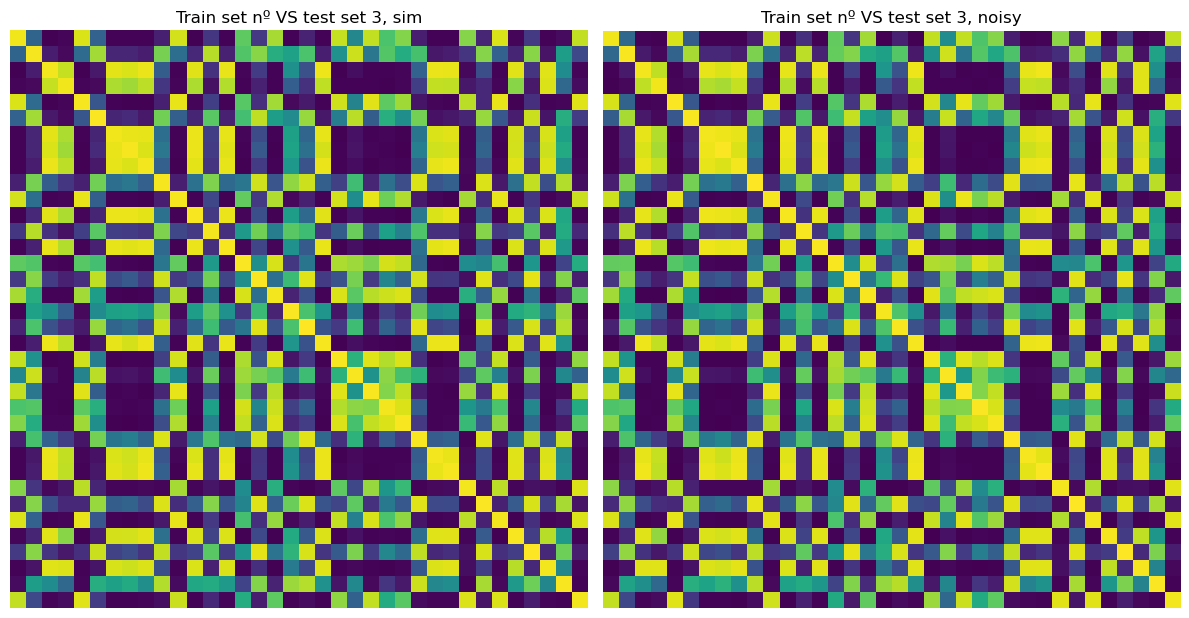

In [61]:
# Plot the kernels for each pair of train sets
labels = ['sim','noisy']

for k in range(3):
    plot_matrixes(aer_trained_kernels[k],['Train set nº '+str(k+1)+', '+label for label in labels])
    plot_matrixes(aer_trained_kernels[k],['Train set nº VS test set '+str(k+1)+', '+label for label in labels])
    print("\n")

### Aer Quantum Support Vector Classifiers

In [62]:
aer_QSVC_list = [[QSVC(quantum_kernel=qkernel, probability=True) for qkernel in sub_train_set] for sub_train_set in aer_qkernels]

Fit the Support Vector Classifiers to the correspondent train data

In [63]:
for k,sub_train_set in tqdm(enumerate(aer_QSVC_list)):
    for qsvc in tqdm(sub_train_set):
        qsvc.fit(X_subtrain_sets[k], y_subtrain_sets[k])

0it [00:00, ?it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb5febbc610>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)


 50%|█████     | 1/2 [00:02<00:02,  2.98s/it]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb61d206eb0>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)


100%|██████████| 2/2 [00:06<00:00,  3.13s/it]
1it [00:06,  6.25s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb5fd9bdac0>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)


 50%|█████     | 1/2 [00:02<00:02,  2.92s/it]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb5ff641100>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)


100%|██████████| 2/2 [00:05<00:00,  2.99s/it]
2it [00:12,  6.10s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb5fc6d0df0>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)


 50%|█████     | 1/2 [00:03<00:03,  3.12s/it]

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=True,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fb5febf3fa0>,
     random_state=2023, shrinking=True, tol=0.001, verbose=False)


100%|██████████| 2/2 [00:06<00:00,  3.13s/it]
3it [00:18,  6.17s/it]


Print the scores of the classifiers

In [64]:
# # Train scores (in case you want to see them)
# aer_QSVC_train_score = [
#     [qsvc.score(X_subtrain_sets[k], y_subtrain_sets[k]) for qsvc in sub_train_set]
#     for k,sub_train_set in enumerate(aer_QSVC_list)
# ]
# print(aer_QSVC_train_score)

#### Performance score over the test set

We can obtaing an overall performance score over the test set for all the trained QSVC

In [65]:
# Obtain the test scores
aer_QSVC_test_scores = [
    [qsvc.score(X_test, y_test.apply(lambda x: 1 if x==classes[k] else 0)) for qsvc in tqdm(sub_train_set)]
    for k,sub_train_set in tqdm(enumerate(aer_QSVC_list))
]
# Note that y_test contains the 3 different labels, we set to 0 the other 2 labels
print(aer_QSVC_test_scores)

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:19<00:00,  9.98s/it]
1it [00:19, 19.96s/it]
100%|██████████| 2/2 [00:19<00:00,  9.97s/it]
2it [00:39, 19.95s/it]
100%|██████████| 2/2 [00:20<00:00, 10.06s/it]
3it [01:00, 20.01s/it]

[[1.0, 1.0], [0.9523809523809523, 0.9523809523809523], [0.9523809523809523, 0.9523809523809523]]


- For the first training set, all clasifier perform perfectly.
- For the second and third training set, we reach the almost the same accuracy for all cases (around 95%).
- The performance is the almost the same to the one of the Statevector simulations. 

To evaluate the performance of the 3 classifiers over the whole test set, per each method, we will chose the label of the prediction with highest probability.

We only need the probability of the item in the test set being of the class that distinguishes the classifier that has been trained with the one vs all approach.

In [66]:
# Obtain the predicted probabilities for each class for each example in X_test
aer_QSVC_test_predictions = [[aer_QSVC_list[k][i].predict_proba(X_test)[:,1] for k in range(3)] for i in range(2)]
# Note that we now group first per simulation method and them per train group!

# Combine the predicted probabilities for all train sets into a single matrix for each simulation method
aer_QSVC_stacked_test_predictions = [np.vstack(simulation_method).T for simulation_method in aer_QSVC_test_predictions]

# Obtain the predicted labels (0,1 or 2) with the highest confidence
aer_QSVC_predicted_labels = [np.argmax(simulation_method, axis=1) for simulation_method in aer_QSVC_stacked_test_predictions] 

In [67]:
simulation_method_names = ['noiselees','noisy']
aer_QSVC_missclassified = [[],[]]
for i,simulation_method in enumerate(aer_QSVC_predicted_labels):
    for index,(predicted_label, true_label) in enumerate(zip(simulation_method,y_test)):
        # Match the numeric labels (0,1 or 2) with the names in the 'classes' objects
        if classes[predicted_label] != true_label:
            aer_QSVC_missclassified[i].append(index)
    print(f"There are {len(aer_QSVC_missclassified[i])} missclassified items out of {len(y_test)}"
          f" for the {simulation_method_names[i]} simulation: {aer_QSVC_missclassified[i]}")

There are 2 missclassified items out of 42 for the noiselees simulation: [14, 31]
There are 2 missclassified items out of 42 for the noisy simulation: [14, 31]


In [68]:
aer_QSVC_accuracy = [1-(len(aer_QSVC_missclassified[i])/len(y_test)) for i in range(2)]
print("Statevector SVM joint accuracy:")
for i in range(2):
    print(f"{simulation_method_names[i]} simulation: {aer_QSVC_accuracy[i]}")

Statevector SVM joint accuracy:
noiselees simulation: 0.9523809523809523
noisy simulation: 0.9523809523809523


- All aer simulation types have the same accuracy over the test set, which is also the same as the Statevector past approach.
- The missclassified items are the same as before.

#### Missclassified data

In [69]:
aer_QSVC_prediction_datasets = []
for simulation_index,simulation_method in enumerate(aer_QSVC_missclassified):
    # for missclassified_index in simulation_method:
    aer_QSVC_prediction_datasets.append(
        pd.DataFrame(
            [
                [missclassified_index] + 
                list(aer_QSVC_stacked_test_predictions[simulation_index][missclassified_index]) + 
                [y_test.iloc[missclassified_index]] 
                for missclassified_index in simulation_method
            ], columns = ['index']+classes+['True label']
        ).set_index('index').style.set_caption(simulation_method_names[simulation_index])
    )
    
for dataset in aer_QSVC_prediction_datasets:
    dataset
    print("\n")

,Iris-setosa,Iris-versicolor,Iris-virginica,True label
index,,,,
14,0.037093,0.491096,0.200629,Iris-virginica
31,0.027829,0.346228,0.552481,Iris-versicolor


,Iris-setosa,Iris-versicolor,Iris-virginica,True label
index,,,,
14,0.034143,0.500000,0.223040,Iris-virginica
31,0.027808,0.327678,0.567134,Iris-versicolor


We see that the labels of these items are predicted with nearly 50% confidence, similar to the previous Statevector case.

## Classical Support Vector Classifiers:

In [70]:
from sklearn.svm import SVC

We select a a small pool of classical kernel types that are avaliable to benchmark and compare with the previous Support Vector Machines.

In [71]:
classical_kernel_types = {'linear', 'poly', 'rbf', 'sigmoid'}
classical_svm_list = [[SVC(kernel = kernel_type,probability=True) for kernel_type in classical_kernel_types] for k in range(3)]

Fit the classical SVC with the data

In [72]:
%%time
for k,sub_train_set in tqdm(enumerate(classical_svm_list)):
    for svm in tqdm(sub_train_set):
        svm.fit(X_subtrain_sets[k], y_subtrain_sets[k],)

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 609.28it/s]

100%|██████████| 4/4 [00:00<00:00, 527.83it/s]

100%|██████████| 4/4 [00:00<00:00, 734.55it/s]
3it [00:00, 126.23it/s]

CPU times: user 20.8 ms, sys: 4.9 ms, total: 25.7 ms
Wall time: 24.7 ms


In [73]:
# # Train scores (in case you want to see them)
# classical_train_scores = [
#     [qkernel.score(X_subtrain_sets[k], y_subtrain_sets[k]) for qkernel in sub_train_set]
#     for k,sub_train_set in enumerate(classical_svm_list)
# ]
# print(classical_train_scores)

Overall test scores of the classical classifiers:

In [74]:
# Obtain the test scores
classical_test_scores = [
    [ckernel.score(X_test, y_test.apply(lambda x: 1 if x==classes[k] else 0)) for ckernel in sub_train_set]
    for k,sub_train_set in enumerate(classical_svm_list)
]
print(classical_test_scores)

[[1.0, 0.9761904761904762, 1.0, 1.0], [0.6666666666666666, 0.6666666666666666, 0.9523809523809523, 0.6666666666666666], [0.9047619047619048, 0.9285714285714286, 0.9285714285714286, 0.9761904761904762]]


- We see that using different kernels, we can get up to 100%, 95% and 97% accuracy over the different train sets, respectively.
- In comparison to the statevector simulation and the aer simulations, there is a better performance over the last train set.

To compare with the previous cases, we will select the best classifier for each training set.

In [75]:
best_classical_svm = [sub_train_set[np.argmax(classical_test_scores[index])] for index,sub_train_set in enumerate(classical_svm_list)]
print(best_classical_svm)

[SVC(kernel='poly', probability=True), SVC(probability=True), SVC(kernel='linear', probability=True)]


In [76]:
# Obtain the predicted probabilities for each class for each example in X_test
classical_test_predictions = [best_classical_svm[k].predict_proba(X_test)[:,1] for k in range(3)]

# Combine the predicted probabilities for all train sets into a single matrix for each simulation method
classical_stacked_test_predictions = np.vstack(classical_test_predictions).T

# Obtain the predicted labels (0,1 or 2) with the highest confidence
classical_predicted_labels = np.argmax(classical_stacked_test_predictions, axis=1)

In [77]:
classical_missclassified = []
for index,(predicted_label, true_label) in enumerate(zip(classical_predicted_labels,y_test)):
    # Match the numeric labels (0,1 or 2) with the names in the 'classes' objects
    if classes[predicted_label] != true_label:
        classical_missclassified.append(index)
print(f"{len(classical_missclassified)} missclassified item(s) out of {len(y_test)}: {classical_missclassified}")

2 missclassified item(s) out of 42: [10, 14]


In [78]:
classical_accuracy = 1-(len(classical_missclassified)/len(y_test))
print("Best classical classifiers joint accuracy",classical_accuracy)

Best classical classifiers joint accuracy 0.9523809523809523


In [79]:
classical_predictions = pd.concat([pd.DataFrame(classical_test_predictions).transpose(), pd.DataFrame(y_test.values)], axis=1)
classical_predictions.columns = [item+' vs. all' for item in classes]+['true_value']
classical_predictions.iloc[classical_missclassified]

,Iris-setosa vs. all,Iris-versicolor vs. all,Iris-virginica vs. all,true_value
10,0.056235,0.530954,0.527777,Iris-virginica
14,0.059777,0.653218,0.353268,Iris-virginica


The item 14 was missclassified in the previous approaches, the item 10 wasn't!

In [80]:
X_test_invscaled.iloc[classical_missclassified]
# Default colors
classical_colors = [palette[y_test.iloc[i]] for i in range(len(y_test))] 
new_colors = ['pink','yellow','orange','purple','brown']
count = 0
for index in classical_missclassified:
    classical_colors[index] = new_colors[count]
    count +=1

,sepal_length,sepal_width,petal_length,petal_width
10,6.2,2.8,4.8,1.8
14,6.3,2.8,5.1,1.5


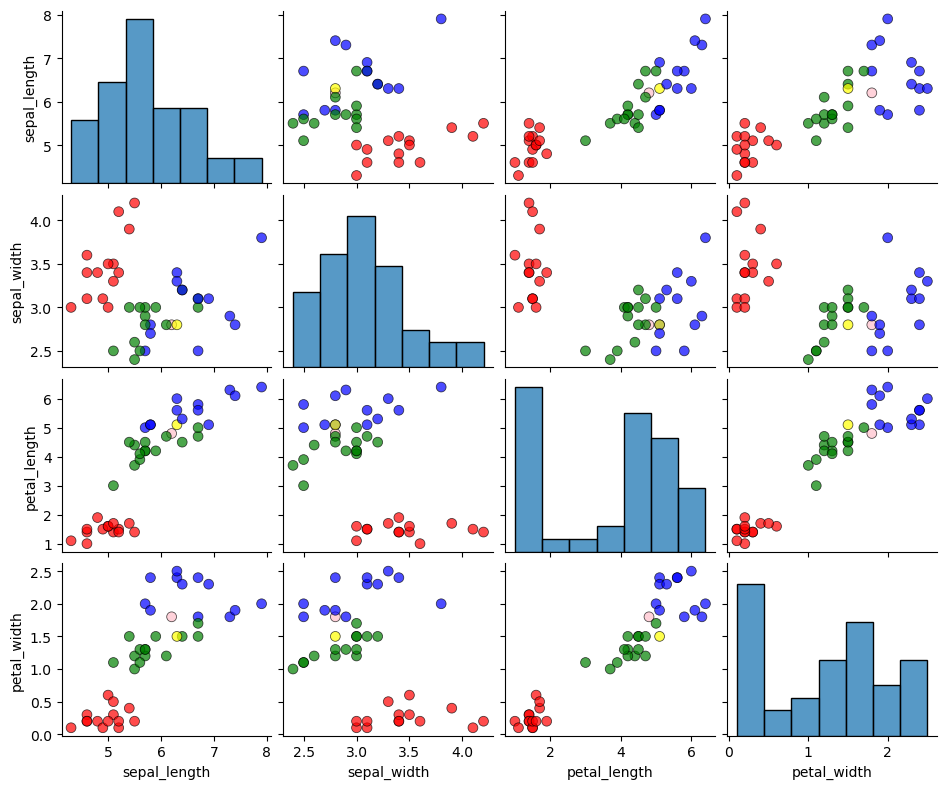

True colors {'Iris-setosa': 'red', 'Iris-versicolor': 'green', 'Iris-virginica': 'blue'}


Item 10, the pink data point has been classified as 'Iris-versicolor'(green) with a likelihood of 53.1%. True label is 'Iris-virginica' (blue)
Item 14, the yellow data point has been classified as 'Iris-versicolor'(green) with a likelihood of 65.32%. True label is 'Iris-virginica' (blue)


In [81]:
sns.pairplot(X_test_invscaled, plot_kws={'s': 50, 'edgecolor': 'k', 'alpha': 0.7, 'color': classical_colors},
             height=2, aspect=1.2, diag_kind='hist')
plt.show()
print("True colors",palette)
print("\n")
for index in classical_missclassified:
    print(f"Item {index}, the {classical_colors[index]} data point has been classified as '{classes[np.argmax(classical_predictions.iloc[index].tolist()[:-1])]}'"
          f"({palette[classes[np.argmax(classical_predictions.iloc[index].tolist()[:-1])]]})"
          f" with a likelihood of {np.round(np.max(classical_predictions.iloc[index].tolist()[:-1])*100,2)}%."
          f" True label is '{classical_predictions.iloc[index].tolist()[-1]}' ({palette[classical_predictions.iloc[index].tolist()[-1]]})")

# Conclusion:

We have managed to successfully classify with a 95% confindence the 3 types of flowers. We have done 2 quantum based approaches using only 2 qubits, that perform well even when introducing noise.
We have also tried using various classical classifiers that perform with the same accuracy as the quantum ones.

In [82]:
import qiskit.tools.jupyter
%qiskit_version_table